# Test imputation on untyped SNPs chrom 18

In [1]:
using Revise
using VCFTools
using MendelImpute
using GeneticVariation
using Random
using StatsBase
using CodecZlib
using ProgressMeter
using JLSO
using BenchmarkTools
using GroupSlices
using LinearAlgebra
# using ProfileView

BLAS.set_num_threads(1)

┌ Info: Precompiling MendelImpute [e47305d1-6a61-5370-bc5d-77554d143183]
└ @ Base loading.jl:1278


In [10]:
# 8 threads, d = 1000
Random.seed!(2020)
chr = 18
maf = 0.1
d = 1000
overlap = 0.0
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.maxd$d.overlap$overlap.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.vcf.gz"
@time ph = phase(tgtfile, reffile, outfile);

X_complete = convert_gt(UInt8, "target.chr18.full.vcf.gz")
n, p = size(X_complete)
X_mendel = convert_gt(UInt8, outfile)
println("error overall = $(sum(X_mendel .!= X_complete) / n / p) \n")
# rm(outfile, force=true)

Number of threads = 8
Importing reference haplotype data...
Total windows = 2367, averaging ~ 527 unique haplotypes per window.

Timings: 
    Data import                     = 21.3053 seconds
        import target data             = 2.86344 seconds
        import compressed haplotypes   = 18.4419 seconds
    Computing haplotype pair        = 4.19614 seconds
        BLAS3 mul! to get M and N      = 0.298691 seconds per thread
        haplopair search               = 3.47523 seconds per thread
        initializing missing           = 0.0215332 seconds per thread
        allocating and viewing         = 0.0514944 seconds per thread
        index conversion               = 0.00119099 seconds per thread
    Phasing by win-win intersection = 1.34342 seconds
        Window-by-window intersection  = 0.0943886 seconds per thread
        Breakpoint search              = 0.973515 seconds per thread
        Recording result               = 0.0260911 seconds per thread
    Imputation              

In [14]:
# 8 threads, d = 1000
Random.seed!(2020)
chr = 18
maf = 0.1
d = 1000
overlap = 0.0
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.maxd$d.overlap$overlap.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.vcf.gz"
@time ph = phase(tgtfile, reffile, outfile);

X_complete = convert_gt(UInt8, "target.chr18.full.vcf.gz")
n, p = size(X_complete)
X_mendel = convert_gt(UInt8, outfile)
println("error overall = $(sum(X_mendel .!= X_complete) / n / p) \n")
# rm(outfile, force=true)

Number of threads = 8
Importing reference haplotype data...
Total windows = 2367, averaging ~ 527 unique haplotypes per window.

Timings: 
    Data import                     = 24.2939 seconds
        import target data             = 4.03945 seconds
        import compressed haplotypes   = 20.2544 seconds
    Computing haplotype pair        = 4.14796 seconds
        BLAS3 mul! to get M and N      = 0.316513 seconds per thread
        haplopair search               = 3.41119 seconds per thread
        initializing missing           = 0.0212078 seconds per thread
        allocating and viewing         = 0.0508483 seconds per thread
        index conversion               = 0.00139291 seconds per thread
    Phasing by win-win intersection = 1.34999 seconds
        Window-by-window intersection  = 0.0945875 seconds per thread
        Breakpoint search              = 0.982726 seconds per thread
        Recording result               = 0.0267201 seconds per thread
    Imputation              

In [15]:
using GeneticVariation
snpscores = Vector{Float64}(undef, nrecords(outfile))

# loop over SNPs
for (i, record) in enumerate(VCF.Reader(openvcf(outfile, "r")))
    snpscores[i] = parse(Float64, VCF.info(record)[1].second)
end

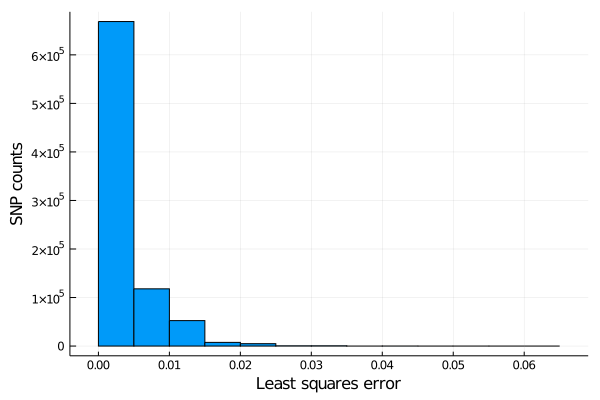

In [22]:
# plot histogram of SNP scores
using Plots
histogram(snpscores, label=:none, xlabel="Least squares error", ylabel="SNP counts", bins=20)

## Generate subset of markers for prephasing

In [3]:
cd("/Users/biona001/.julia/dev/MendelImpute/data/1000_genome_phase3_v5/filtered")
function filter_and_mask()
    for chr in [18]
        # filter chromosome data for unique snps
        data = "../beagle_raw/chr$chr.1kg.phase3.v5a.vcf.gz"
        full_record_index = .!find_duplicate_marker(data)
        @time VCFTools.filter(data, full_record_index, 1:nsamples(data), 
            des = "chr$chr.uniqueSNPs.vcf.gz")

        # summarize data
        total_snps, samples, _, _, _, maf_by_record, _ = gtstats("chr$chr.uniqueSNPs.vcf.gz")

        # generate target panel with all snps
        n = 100
        sample_idx = falses(samples)
        sample_idx[1:n] .= true
        shuffle!(sample_idx)
        @time VCFTools.filter("chr$chr.uniqueSNPs.vcf.gz", 1:total_snps, 
            sample_idx, des = "target.chr$chr.full.vcf.gz", allow_multiallelic=false)

        # also generate reference panel without target samples
        @time VCFTools.filter("chr$chr.uniqueSNPs.vcf.gz", 1:total_snps, 
            .!sample_idx, des = "ref.chr$chr.excludeTarget.vcf.gz", allow_multiallelic=false)
        
        for maf in [0.0005, 0.001, 0.01, 0.1, 0.45]
            
            # generate target file with 100 samples and typed snps with certain maf
            my_maf = findall(x -> x > maf, maf_by_record)  
            p = length(my_maf)
            record_idx = falses(total_snps)
            record_idx[my_maf] .= true
            @time VCFTools.filter("chr$chr.uniqueSNPs.vcf.gz", record_idx, sample_idx, 
                des = "target.chr$chr.typedOnly.maf$maf.vcf.gz", allow_multiallelic=false)

            # unphase and mask 1% entries in target file
            masks = falses(p, n)
            missingprop = 0.001
            for j in 1:n, i in 1:p
                rand() < missingprop && (masks[i, j] = true)
            end
            @time mask_gt("target.chr$chr.typedOnly.maf$maf.vcf.gz", masks, 
                des="target.chr$chr.typedOnly.maf$maf.masked.vcf.gz", unphase=true)
        end
    end 
end
Random.seed!(2020)
@time filter_and_mask()

752.076342 seconds (6.51 G allocations: 615.353 GiB, 7.01% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:08:17


549.100648 seconds (6.86 G allocations: 650.723 GiB, 10.18% gc time)
1139.017251 seconds (16.68 G allocations: 1.249 TiB, 10.94% gc time)
599.893049 seconds (6.86 G allocations: 650.911 GiB, 10.61% gc time)
 36.158916 seconds (267.39 M allocations: 27.452 GiB, 6.96% gc time)
608.676819 seconds (6.83 G allocations: 648.780 GiB, 10.30% gc time)
 35.610763 seconds (249.89 M allocations: 25.655 GiB, 6.86% gc time)
560.687780 seconds (6.61 G allocations: 626.620 GiB, 10.27% gc time)
 16.352906 seconds (119.38 M allocations: 12.252 GiB, 6.40% gc time)
520.047088 seconds (6.51 G allocations: 615.447 GiB, 10.21% gc time)
  8.014085 seconds (53.29 M allocations: 5.482 GiB, 5.36% gc time)
516.890704 seconds (6.43 G allocations: 607.361 GiB, 10.60% gc time)
  0.831218 seconds (5.35 M allocations: 563.018 MiB, 5.66% gc time)
6410.931663 seconds (76.92 G allocations: 6.823 TiB, 10.06% gc time)


In [2]:
@show nrecords("ref.chr18.excludeTarget.vcf.gz")

nrecords("ref.chr18.excludeTarget.vcf.gz") = 852602


852602

In [3]:
@show nrecords("target.chr18.typedOnly.maf0.1.masked.vcf.gz")

nrecords("target.chr18.typedOnly.maf0.1.masked.vcf.gz") = 169914


169914

# Try jlso/jld2 compression

In [4]:
# jlso format
maf = 0.1
max_d = [1000]
minwidths = [100, 250, 400, 600]
# overlaps = [0.25, 0.5, 0.75, 1.0]
overlap = 0.0

# reffile = "ref.chr18.excludeTarget.vcf.gz"
# tgtfile = "target.chr18.typedOnly.maf$maf.masked.vcf.gz"
# H, H_sampleID, H_chr, H_pos, H_ids, H_ref, H_alt = convert_ht(Bool, reffile, trans=true, save_snp_info=true, msg="importing reference data...")
# X, X_sampleID, X_chr, X_pos, X_ids, X_ref, X_alt = VCFTools.convert_gt(UInt8, tgtfile, trans=true, save_snp_info=true, msg = "Importing genotype file...")
for d in max_d, minwidth in minwidths
    outfile = "ref.chr18.maxd$d.minwidth$minwidth.maf$maf.excludeTarget.jlso"
    @time compress_haplotypes(H, X, outfile, X_pos, H_sampleID, H_chr, H_pos, H_ids, 
        H_ref, H_alt, d, minwidth, overlap)
end

295.751250 seconds (50.45 M allocations: 72.668 GiB, 3.59% gc time)
236.530047 seconds (21.33 M allocations: 38.930 GiB, 2.25% gc time)
202.031370 seconds (14.28 M allocations: 21.577 GiB, 1.75% gc time)
188.489177 seconds (14.28 M allocations: 21.577 GiB, 2.12% gc time)


In [4]:
;ls -al ref.chr18.excludeTarget.vcf.gz

-rw-r--r--@ 1 biona001  staff  247072174 May 19 23:43 ref.chr18.excludeTarget.vcf.gz


In [5]:
;ls -al ref.chr18.maxd1000.maf0.1.excludeTarget.jlso

-rw-r--r--  1 biona001  staff  130476381 Aug  4 23:43 ref.chr18.maxd1000.maf0.1.excludeTarget.jlso


In [6]:
;ls -al ref.chr18.maxd1000.minwidth20.maf0.1.excludeTarget.jlso

-rw-r--r--  1 biona001  staff  130259083 Sep  6 16:53 ref.chr18.maxd1000.minwidth20.maf0.1.excludeTarget.jlso


# MendelImpute error rate and timing

In [5]:
Threads.nthreads()

8

In [11]:
# 8 threads, keep best happair
Random.seed!(2020)
chr = 18
maf = 0.1
width = 512
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.$width.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.dp$width.maf$maf.vcf.gz"
@time ph, hs = phase(tgtfile, reffile, outfile=outfile, impute=true, width=width)

X_complete = convert_gt(UInt8, "target.chr18.full.vcf.gz")
n, p = size(X_complete)
X_mendel = convert_gt(UInt8, outfile)
println("error overall = $(sum(X_mendel .!= X_complete) / n / p) \n")

Computing optimal haplotype pairs...100%|███████████████| Time: 0:01:06
Writing to file...100%|█████████████████████████████████| Time: 0:00:06


Total windows = 331, averaging ~ 4096 unique haplotypes per window.

Timings: 
    Data import                     = 10.6795 seconds
    Computing haplotype pair        = 66.8235 seconds
        BLAS3 mul! to get M and N      = 8.81538 seconds per thread
        haplopair search               = 43.7844 seconds per thread
        supplying constant terms       = 0.00405961 seconds per thread
        finding redundant happairs     = 0.0471254 seconds per thread
    Phasing by dynamic programming  = 0.325226 seconds
    Imputation                      = 9.08613 seconds

 87.094466 seconds (53.87 M allocations: 29.474 GiB, 6.25% gc time)
error overall = 0.006451474427693109 



# Imputation of typed SNPs only

In [16]:
# 8 threads, d = 1000
Random.seed!(2020)
tgtfile = "target.chr18.typedOnly.maf0.1.masked.vcf.gz"
reffile = "ref.chr18.maxd1000.overlap$overlap.maf0.1.excludeTarget.jlso"
outfile = "mendel.imputed.vcf.gz"
@time ph = phase(tgtfile, reffile, outfile, impute=false);

X_complete = convert_gt(UInt8, "target.chr18.typedOnly.maf0.1.vcf.gz")
n, p = size(X_complete)
X_mendel = convert_gt(UInt8, outfile)
println("error overall = $(sum(X_mendel .!= X_complete) / n / p) \n")
rm(outfile, force=true)

Number of threads = 8
Importing reference haplotype data...
Total windows = 2367, averaging ~ 527 unique haplotypes per window.

Timings: 
    Data import                     = 22.0836 seconds
        import target data             = 3.89646 seconds
        import compressed haplotypes   = 18.1871 seconds
    Computing haplotype pair        = 4.13377 seconds
        BLAS3 mul! to get M and N      = 0.309622 seconds per thread
        haplopair search               = 3.42762 seconds per thread
        initializing missing           = 0.021281 seconds per thread
        allocating and viewing         = 0.0506452 seconds per thread
        index conversion               = 0.00123344 seconds per thread
    Phasing by win-win intersection = 1.28608 seconds
        Window-by-window intersection  = 0.0921849 seconds per thread
        Breakpoint search              = 0.952759 seconds per thread
        Recording result               = 0.0200383 seconds per thread
    Imputation               

# MendelImpute with intersecting win-by-win

In [10]:
# 8 threads, d = 1000, keep best happair
Random.seed!(2020)
chr = 18
maf = 0.1
d = 1000
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.maxd$d.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.vcf.gz"
@time ph = phase(tgtfile, reffile, outfile=outfile, impute=true, max_d = d,
    dynamic_programming = false)

X_complete = convert_gt(UInt8, "target.chr18.full.vcf.gz")
n, p = size(X_complete)
X_mendel = convert_gt(UInt8, outfile)
println("error overall = $(sum(X_mendel .!= X_complete) / n / p) \n")
rm(outfile, force=true)

Importing reference haplotype data...


Writing to file...100%|█████████████████████████████████| Time: 0:00:05


Total windows = 2367, averaging ~ 527 unique haplotypes per window.

Timings: 
    Data import                     = 13.8701 seconds
    Computing haplotype pair        = 4.40941 seconds
        BLAS3 mul! to get M and N      = 0.3572 seconds per thread
        haplopair search               = 3.40097 seconds per thread
        initializing missing           = 0.0227854 seconds per thread
        allocating and viewing         = 0.0552744 seconds per thread
        index conversion               = 0.00175442 seconds per thread
    Phasing by win-win intersection = 0.150916 seconds
        Window-by-window intersection  = 0.0993135 seconds per thread
        Breakpoint search              = 0.0233533 seconds per thread
        Recording result               = 0.0133309 seconds per thread
    Imputation                      = 6.13664 seconds

 24.567881 seconds (62.44 M allocations: 4.900 GiB, 6.45% gc time)
error overall = 0.005046844834987485 



In [3]:
# 8 threads with Gaius.jl
Random.seed!(2020)
chr = 18
maf = 0.1
width = 512
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.$width.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.dp$width.maf$maf.vcf.gz"
@time ph = phase(tgtfile, reffile, outfile=outfile, impute=true, width=width,
    dynamic_programming = false)

X_complete = convert_gt(UInt8, "target.chr18.full.vcf.gz")
n, p = size(X_complete)
X_mendel = convert_gt(UInt8, outfile)
println("error overall = $(sum(X_mendel .!= X_complete) / n / p) \n")

Importing reference haplotype data...


Phasing chunk 1/1...100%|███████████████████████████████| Time: 0:01:25
Writing to file...100%|█████████████████████████████████| Time: 0:00:06


Total windows = 331, averaging ~ 4096 unique haplotypes per window.

Timings: 
    Data import                     = 9.22319 seconds
    Computing haplotype pair        = 85.1134 seconds
        BLAS3 mul! to get M and N      = 40.7029 seconds per thread
        haplopair search               = 38.7822 seconds per thread
        finding redundant happairs     = 0.0075832 seconds per thread
    Phasing by win-win intersection = 0.037751 seconds
    Imputation                      = 8.35549 seconds

102.829221 seconds (57.19 M allocations: 29.451 GiB, 4.87% gc time)
error overall = 0.006448636057621258 



In [3]:
# 8 threads with PaddedMatrices.jl
Random.seed!(2020)
chr = 18
maf = 0.1
width = 512
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.$width.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.dp$width.maf$maf.vcf.gz"
@time ph = phase(tgtfile, reffile, outfile=outfile, impute=true, width=width,
    dynamic_programming = false)

X_complete = convert_gt(UInt8, "target.chr18.full.vcf.gz")
n, p = size(X_complete)
X_mendel = convert_gt(UInt8, outfile)
println("error overall = $(sum(X_mendel .!= X_complete) / n / p) \n")

Importing reference haplotype data...


Phasing chunk 1/1...100%|███████████████████████████████| Time: 0:00:57
Writing to file...100%|█████████████████████████████████| Time: 0:00:07


Total windows = 331, averaging ~ 4096 unique haplotypes per window.

Timings: 
    Data import                     = 9.23164 seconds
    Computing haplotype pair        = 57.9442 seconds
        BLAS3 mul! to get M and N      = 14.6295 seconds per thread
        haplopair search               = 34.661 seconds per thread
        finding redundant happairs     = 0.00644955 seconds per thread
    Phasing by win-win intersection = 0.0497861 seconds
    Imputation                      = 7.60605 seconds

 75.064026 seconds (52.82 M allocations: 29.050 GiB, 6.18% gc time)
error overall = 0.0064488354472544045 



# MendelPhase

In [3]:
# 8 threads, keep best happair
Random.seed!(2020)
chr = 18
maf = 0.1
width = 512
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.$width.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.dp$width.maf$maf.vcf.gz"
@time ph = phase(tgtfile, reffile, outfile=outfile, impute=true, width=width,
    dynamic_programming = false, phase=true)

X_complete = convert_gt(UInt8, "target.chr18.full.vcf.gz")
n, p = size(X_complete)
X_mendel = convert_gt(UInt8, outfile)
println("error overall = $(sum(X_mendel .!= X_complete) / n / p) \n")

Importing reference haplotype data...


Phasing chunk 1/1...100%|███████████████████████████████| Time: 0:00:50
Writing to file...100%|█████████████████████████████████| Time: 0:00:06


Total windows = 331, averaging ~ 4096 unique haplotypes per window.

Timings: 
    Data import                     = 9.3601 seconds
    Computing haplotype pair        = 50.7812 seconds
        BLAS3 mul! to get M and N      = 11.7251 seconds per thread
        haplopair search               = 33.0267 seconds per thread
        finding redundant happairs     = 0.0309747 seconds per thread
    Phasing by win-win intersection = 0.0394528 seconds
    Imputation                      = 7.16706 seconds

 67.442743 seconds (54.67 M allocations: 29.016 GiB, 6.78% gc time)
error overall = 0.012744234707401578 



# Ultra compressed output

In [6]:
# 8 threads, d = 1000, keep best happair
Random.seed!(2020)
chr = 18
maf = 0.1
d = 1000
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.maxd$d.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.jlso"
@time ph = phase(tgtfile, reffile, outfile=outfile, impute=true, max_d = d,
    phase = true);

X_complete = convert_gt(UInt8, "target.chr18.full.vcf.gz", trans=true)
H = convert_ht(Bool, "ref.chr18.excludeTarget.vcf.gz", trans=true, msg="importing H")
n, p = size(X_complete)
X1, X2 = convert_compressed(UInt8, ph, H)
X_mendel = X1 + X2
println("error overall = $(sum(X_mendel .!= X_complete) / n / p) \n")
# rm(outfile, force=true)

Number of threads = 8
Importing reference haplotype data...
Total windows = 2367, averaging ~ 527 unique haplotypes per window.

Timings: 
    Data import                     = 15.7743 seconds
        import target data             = 3.88648 seconds
        import compressed haplotypes   = 11.8878 seconds
    Computing haplotype pair        = 4.2701 seconds
        BLAS3 mul! to get M and N      = 0.331793 seconds per thread
        haplopair search               = 3.49273 seconds per thread
        initializing missing           = 0.0225607 seconds per thread
        allocating and viewing         = 0.0592994 seconds per thread
        index conversion               = 0.00190718 seconds per thread
    Phasing by win-win intersection = 1.60634 seconds
        Window-by-window intersection  = 0.0996143 seconds per thread
        Breakpoint search              = 1.05511 seconds per thread
        Recording result               = 0.0110744 seconds per thread
    Imputation                

importing H100%|████████████████████████████████████████| Time: 0:04:07


error overall = 0.005259159607882693 



In [7]:
;ls -al mendel.imputed.jlso

-rw-r--r--  1 biona001  staff  983248 Sep  7 14:40 mendel.imputed.jlso


In [8]:
;ls -al mendel.imputed.vcf.gz

-rw-r--r--  1 biona001  staff  17876617 Sep  7 14:36 mendel.imputed.vcf.gz


In [9]:
17876617 / 983248

18.18118826582917

# Minimum window widths

In [11]:
# 8 threads, global search, d = 1000, minwidth=0
Random.seed!(2020)
chr = 18
maf = 0.1
d = 1000
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.maxd$d.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.vcf.gz"
@time ph = phase(tgtfile, reffile, outfile=outfile, impute=true, max_d=d,
    phase = true);

# X_complete = convert_gt(UInt8, "target.chr18.full.vcf.gz")
n, p = size(X_complete)
X_mendel = convert_gt(UInt8, outfile)
println("error overall = $(sum(X_mendel .!= X_complete) / n / p) \n")
# rm(outfile, force=true)

Number of threads = 8
Importing reference haplotype data...
Total windows = 2367, averaging ~ 527 unique haplotypes per window.

Timings: 
    Data import                     = 16.692 seconds
        import target data             = 4.87187 seconds
        import compressed haplotypes   = 11.8201 seconds
    Computing haplotype pair        = 4.26173 seconds
        BLAS3 mul! to get M and N      = 0.321671 seconds per thread
        haplopair search               = 3.45778 seconds per thread
        initializing missing           = 0.0235874 seconds per thread
        allocating and viewing         = 0.0624623 seconds per thread
        index conversion               = 0.00164948 seconds per thread
    Phasing by win-win intersection = 1.50478 seconds
        Window-by-window intersection  = 0.100988 seconds per thread
        Breakpoint search              = 1.11491 seconds per thread
        Recording result               = 0.0143302 seconds per thread
    Imputation                 

In [12]:
# 8 threads, global search, d = 1000, minwidth=20
Random.seed!(2020)
chr = 18
maf = 0.1
d = 1000
minwidth = 20
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.maxd$d.minwidth$minwidth.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.vcf.gz"
@time ph = phase(tgtfile, reffile, outfile=outfile, impute=true, max_d=d,
    phase = true);

# X_complete = convert_gt(UInt8, "target.chr18.full.vcf.gz")
n, p = size(X_complete)
X_mendel = convert_gt(UInt8, outfile)
println("error overall = $(sum(X_mendel .!= X_complete) / n / p) \n")
# rm(outfile, force=true)

Number of threads = 8
Importing reference haplotype data...
Total windows = 2351, averaging ~ 538 unique haplotypes per window.

Timings: 
    Data import                     = 23.0568 seconds
        import target data             = 5.07468 seconds
        import compressed haplotypes   = 17.9821 seconds
    Computing haplotype pair        = 5.33693 seconds
        BLAS3 mul! to get M and N      = 0.333737 seconds per thread
        haplopair search               = 3.69525 seconds per thread
        initializing missing           = 0.0251059 seconds per thread
        allocating and viewing         = 0.184637 seconds per thread
        index conversion               = 0.00187568 seconds per thread
    Phasing by win-win intersection = 1.53646 seconds
        Window-by-window intersection  = 0.1011 seconds per thread
        Breakpoint search              = 1.14021 seconds per thread
        Recording result               = 0.0135461 seconds per thread
    Imputation                   

In [14]:
# 8 threads, global search, d = 1000, minwidth=50
Random.seed!(2020)
chr = 18
maf = 0.1
d = 1000
minwidth = 50
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.maxd$d.minwidth$minwidth.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.vcf.gz"
@time ph = phase(tgtfile, reffile, outfile=outfile, impute=true, max_d=d,
    phase = true);

# X_complete = convert_gt(UInt8, "target.chr18.full.vcf.gz")
n, p = size(X_complete)
X_mendel = convert_gt(UInt8, outfile)
println("error overall = $(sum(X_mendel .!= X_complete) / n / p) \n")
# rm(outfile, force=true)

Number of threads = 8
Importing reference haplotype data...


Computing optimal haplotypes...100%|████████████████████| Time: 0:00:17


Total windows = 1715, averaging ~ 902 unique haplotypes per window.

Timings: 
    Data import                     = 17.6011 seconds
        import target data             = 4.61148 seconds
        import compressed haplotypes   = 12.9896 seconds
    Computing haplotype pair        = 20.3727 seconds
        BLAS3 mul! to get M and N      = 1.18181 seconds per thread
        haplopair search               = 9.50708 seconds per thread
        initializing missing           = 0.025314 seconds per thread
        allocating and viewing         = 0.426595 seconds per thread
        index conversion               = 0.00288651 seconds per thread
    Phasing by win-win intersection = 2.24203 seconds
        Window-by-window intersection  = 0.0527586 seconds per thread
        Breakpoint search              = 1.88314 seconds per thread
        Recording result               = 0.0110326 seconds per thread
    Imputation                     = 2.2735 seconds
        Imputing missing               =

In [7]:
# 8 threads, d = 1000, minwidth = 100
Random.seed!(2020)
chr = 18
maf = 0.1
d = 1000
overlap = 0.0
minwidth = 100
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.maxd$d.minwidth$minwidth.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.vcf.gz"
@time ph = phase(tgtfile, reffile, outfile=outfile, phase=true);

X_complete = convert_gt(UInt8, "target.chr18.full.vcf.gz")
n, p = size(X_complete)
X_mendel = convert_gt(UInt8, outfile)
println("error overall = $(sum(X_mendel .!= X_complete) / n / p) \n")
# rm(outfile, force=true)

Number of threads = 8
Importing reference haplotype data...


Importing genotype file...100%|█████████████████████████| Time: 0:00:05
Computing optimal haplotypes...100%|████████████████████| Time: 0:00:37
Phasing...100%|█████████████████████████████████████████| Time: 0:00:06


Total windows = 1010, averaging ~ 1725 unique haplotypes per window.

Timings: 
    Data import                     = 16.2461 seconds
        import target data             = 5.2943 seconds
        import compressed haplotypes   = 10.9518 seconds
    Computing haplotype pair        = 39.9748 seconds
        BLAS3 mul! to get M and N      = 3.35306 seconds per thread
        haplopair search               = 19.4401 seconds per thread
        initializing missing           = 0.0242503 seconds per thread
        allocating and viewing         = 0.517274 seconds per thread
        index conversion               = 0.00267529 seconds per thread
    Phasing by win-win intersection = 6.63678 seconds
        Window-by-window intersection  = 0.0201415 seconds per thread
        Breakpoint search              = 6.2152 seconds per thread
        Recording result               = 0.0182764 seconds per thread
    Imputation                     = 2.45815 seconds
        Imputing missing               

In [8]:
# 8 threads, d = 1000, minwidth = 250
Random.seed!(2020)
chr = 18
maf = 0.1
d = 1000
overlap = 0.0
minwidth = 250
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.maxd$d.minwidth$minwidth.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.vcf.gz"
@time ph = phase(tgtfile, reffile, outfile=outfile, phase=true);

X_complete = convert_gt(UInt8, "target.chr18.full.vcf.gz")
n, p = size(X_complete)
X_mendel = convert_gt(UInt8, outfile)
println("error overall = $(sum(X_mendel .!= X_complete) / n / p) \n")
# rm(outfile, force=true)

Number of threads = 8
Importing reference haplotype data...


Computing optimal haplotypes...100%|████████████████████| Time: 0:00:50
Phasing...100%|█████████████████████████████████████████| Time: 0:00:24


Total windows = 512, averaging ~ 3210 unique haplotypes per window.

Timings: 
    Data import                     = 13.9187 seconds
        import target data             = 3.88211 seconds
        import compressed haplotypes   = 10.0365 seconds
    Computing haplotype pair        = 53.2058 seconds
        BLAS3 mul! to get M and N      = 7.18431 seconds per thread
        haplopair search               = 30.2405 seconds per thread
        initializing missing           = 0.0250812 seconds per thread
        allocating and viewing         = 0.682338 seconds per thread
        index conversion               = 0.00131225 seconds per thread
    Phasing by win-win intersection = 24.3224 seconds
        Window-by-window intersection  = 0.00482951 seconds per thread
        Breakpoint search              = 23.0015 seconds per thread
        Recording result               = 0.0138126 seconds per thread
    Imputation                     = 2.11399 seconds
        Imputing missing             

In [9]:
# 8 threads, d = 1000, minwidth = 400
Random.seed!(2020)
chr = 18
maf = 0.1
d = 1000
overlap = 0.0
minwidth = 400
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.maxd$d.minwidth$minwidth.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.vcf.gz"
@time ph = phase(tgtfile, reffile, outfile=outfile, phase=true);

X_complete = convert_gt(UInt8, "target.chr18.full.vcf.gz")
n, p = size(X_complete)
X_mendel = convert_gt(UInt8, outfile)
println("error overall = $(sum(X_mendel .!= X_complete) / n / p) \n")
# rm(outfile, force=true)

Number of threads = 8
Importing reference haplotype data...


Computing optimal haplotypes...100%|████████████████████| Time: 0:00:41
Phasing...100%|█████████████████████████████████████████| Time: 0:01:19


Total windows = 256, averaging ~ 4450 unique haplotypes per window.

Timings: 
    Data import                     = 13.0042 seconds
        import target data             = 3.90106 seconds
        import compressed haplotypes   = 9.10316 seconds
    Computing haplotype pair        = 44.0709 seconds
        BLAS3 mul! to get M and N      = 9.22317 seconds per thread
        haplopair search               = 27.9716 seconds per thread
        initializing missing           = 0.0263227 seconds per thread
        allocating and viewing         = 0.831811 seconds per thread
        index conversion               = 0.000607927 seconds per thread
    Phasing by win-win intersection = 79.4378 seconds
        Window-by-window intersection  = 0.0016319 seconds per thread
        Breakpoint search              = 75.0606 seconds per thread
        Recording result               = 0.0120721 seconds per thread
    Imputation                     = 2.84468 seconds
        Imputing missing             

In [10]:
# 8 threads, d = 1000, minwidth = 600
Random.seed!(2020)
chr = 18
maf = 0.1
d = 1000
overlap = 0.0
minwidth = 600
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.maxd$d.minwidth$minwidth.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.vcf.gz"
@time ph = phase(tgtfile, reffile, outfile=outfile, phase=true);

X_complete = convert_gt(UInt8, "target.chr18.full.vcf.gz")
n, p = size(X_complete)
X_mendel = convert_gt(UInt8, outfile)
println("error overall = $(sum(X_mendel .!= X_complete) / n / p) \n")
# rm(outfile, force=true)

Number of threads = 8
Importing reference haplotype data...


Computing optimal haplotypes...100%|████████████████████| Time: 0:00:41
Phasing...100%|█████████████████████████████████████████| Time: 0:01:11


Total windows = 256, averaging ~ 4450 unique haplotypes per window.

Timings: 
    Data import                     = 13.6892 seconds
        import target data             = 4.44948 seconds
        import compressed haplotypes   = 9.23969 seconds
    Computing haplotype pair        = 43.7362 seconds
        BLAS3 mul! to get M and N      = 9.11761 seconds per thread
        haplopair search               = 27.6916 seconds per thread
        initializing missing           = 0.025862 seconds per thread
        allocating and viewing         = 0.842874 seconds per thread
        index conversion               = 0.0006032 seconds per thread
    Phasing by win-win intersection = 71.5608 seconds
        Window-by-window intersection  = 0.00138144 seconds per thread
        Breakpoint search              = 67.8754 seconds per thread
        Recording result               = 0.0101877 seconds per thread
    Imputation                     = 2.13964 seconds
        Imputing missing               

# Overlapping windows

In [5]:
function overlap_run()
    chr = 18
    maf = 0.1
    max_d = 1000
    X_complete = convert_gt(UInt8, "target.chr$chr.full.vcf.gz")
    n, p = size(X_complete)
    for overlap in [0.0, 0.1, 0.25, 0.5, 0.75, 1.0]
        tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
        reffile = "ref.chr18.maxd$max_d.overlap$overlap.maf$maf.excludeTarget.jlso"
        outfile = "mendel.imputed.chr$chr.vcf.gz"

        ph = phase(tgtfile, reffile, outfile=outfile, impute=true, max_d=max_d, phase=true)
        X_mendel = convert_gt(UInt8, outfile)
        println("overlap $overlap error = $(sum(X_mendel .!= X_complete) / n / p) \n")
        flush(stdout)
    end
end
Random.seed!(2020)
overlap_run()

Number of threads = 8
Importing reference haplotype data...


Importing genotype file...100%|█████████████████████████| Time: 0:00:05


Total windows = 2367, averaging ~ 527 unique haplotypes per window.

Timings: 
    Data import                     = 23.4574 seconds
        import target data             = 5.23924 seconds
        import compressed haplotypes   = 18.2182 seconds
    Computing haplotype pair        = 4.53151 seconds
        BLAS3 mul! to get M and N      = 0.380729 seconds per thread
        haplopair search               = 3.64957 seconds per thread
        initializing missing           = 0.0240004 seconds per thread
        allocating and viewing         = 0.0684376 seconds per thread
        index conversion               = 0.00326528 seconds per thread
    Phasing by win-win intersection = 1.41532 seconds
        Window-by-window intersection  = 0.105019 seconds per thread
        Breakpoint search              = 1.06294 seconds per thread
        Recording result               = 0.0144047 seconds per thread
    Imputation                     = 2.3351 seconds
        Imputing missing              

Computing optimal haplotypes...100%|████████████████████| Time: 0:00:09


Total windows = 2367, averaging ~ 734 unique haplotypes per window.

Timings: 
    Data import                     = 22.9327 seconds
        import target data             = 4.59166 seconds
        import compressed haplotypes   = 18.341 seconds
    Computing haplotype pair        = 11.1601 seconds
        BLAS3 mul! to get M and N      = 0.775174 seconds per thread
        haplopair search               = 7.77059 seconds per thread
        initializing missing           = 0.0300363 seconds per thread
        allocating and viewing         = 0.338323 seconds per thread
        index conversion               = 0.00296176 seconds per thread
    Phasing by win-win intersection = 2.00624 seconds
        Window-by-window intersection  = 0.0857522 seconds per thread
        Breakpoint search              = 1.76 seconds per thread
        Recording result               = 0.014369 seconds per thread
    Imputation                     = 2.88384 seconds
        Imputing missing               = 0

Computing optimal haplotypes...100%|████████████████████| Time: 0:00:21


Total windows = 2367, averaging ~ 1059 unique haplotypes per window.

Timings: 
    Data import                     = 21.1849 seconds
        import target data             = 4.79981 seconds
        import compressed haplotypes   = 16.3851 seconds
    Computing haplotype pair        = 23.43 seconds
        BLAS3 mul! to get M and N      = 2.21146 seconds per thread
        haplopair search               = 17.5658 seconds per thread
        initializing missing           = 0.0387842 seconds per thread
        allocating and viewing         = 0.524572 seconds per thread
        index conversion               = 0.00475071 seconds per thread
    Phasing by win-win intersection = 1.76297 seconds
        Window-by-window intersection  = 0.0602452 seconds per thread
        Breakpoint search              = 1.52317 seconds per thread
        Recording result               = 0.0145165 seconds per thread
    Imputation                     = 2.34634 seconds
        Imputing missing               

Computing optimal haplotypes...100%|████████████████████| Time: 0:00:47


Total windows = 2367, averaging ~ 1593 unique haplotypes per window.

Timings: 
    Data import                     = 24.5372 seconds
        import target data             = 4.77399 seconds
        import compressed haplotypes   = 19.7632 seconds
    Computing haplotype pair        = 50.4585 seconds
        BLAS3 mul! to get M and N      = 6.07232 seconds per thread
        haplopair search               = 39.456 seconds per thread
        initializing missing           = 0.0527969 seconds per thread
        allocating and viewing         = 0.792506 seconds per thread
        index conversion               = 0.00632086 seconds per thread
    Phasing by win-win intersection = 1.81898 seconds
        Window-by-window intersection  = 0.0360357 seconds per thread
        Breakpoint search              = 1.63553 seconds per thread
        Recording result               = 0.0128104 seconds per thread
    Imputation                     = 2.41322 seconds
        Imputing missing              

Computing optimal haplotypes...100%|████████████████████| Time: 0:01:29


Total windows = 2367, averaging ~ 2099 unique haplotypes per window.

Timings: 
    Data import                     = 20.5885 seconds
        import target data             = 4.75614 seconds
        import compressed haplotypes   = 15.8323 seconds
    Computing haplotype pair        = 92.3361 seconds
        BLAS3 mul! to get M and N      = 12.8246 seconds per thread
        haplopair search               = 72.2983 seconds per thread
        initializing missing           = 0.0705915 seconds per thread
        allocating and viewing         = 1.16329 seconds per thread
        index conversion               = 0.00620707 seconds per thread
    Phasing by win-win intersection = 2.21282 seconds
        Window-by-window intersection  = 0.0263918 seconds per thread
        Breakpoint search              = 2.01263 seconds per thread
        Recording result               = 0.0134365 seconds per thread
    Imputation                     = 2.66718 seconds
        Imputing missing              

Computing optimal haplotypes...100%|████████████████████| Time: 0:02:15


Total windows = 2367, averaging ~ 2542 unique haplotypes per window.

Timings: 
    Data import                     = 19.8248 seconds
        import target data             = 4.70737 seconds
        import compressed haplotypes   = 15.1175 seconds
    Computing haplotype pair        = 138.896 seconds
        BLAS3 mul! to get M and N      = 20.6037 seconds per thread
        haplopair search               = 108.035 seconds per thread
        initializing missing           = 0.0885541 seconds per thread
        allocating and viewing         = 1.66364 seconds per thread
        index conversion               = 0.00720214 seconds per thread
    Phasing by win-win intersection = 2.29939 seconds
        Window-by-window intersection  = 0.0217813 seconds per thread
        Breakpoint search              = 2.13475 seconds per thread
        Recording result               = 0.014543 seconds per thread
    Imputation                     = 2.94009 seconds
        Imputing missing               

# Haplotype rescreening

This is enabled by the "rescreen" option. This option saves a number of top haplotype pairs when solving the least squares objective, and re-minimize least squares on just observed data.

In [3]:
# 8 threads, keep best happair
Random.seed!(2020)
chr = 18
maf = 0.1
width = 512
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.$width.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.dp$width.maf$maf.vcf.gz"
@time ph = phase(tgtfile, reffile, outfile=outfile, impute=true, width=width,
    dynamic_programming = false, rescreen=true)

X_complete = convert_gt(UInt8, "target.chr18.full.vcf.gz")
n, p = size(X_complete)
X_mendel = convert_gt(UInt8, outfile)
println("error overall = $(sum(X_mendel .!= X_complete) / n / p) \n")

Importing reference haplotype data...


Phasing chunk 1/1...100%|███████████████████████████████| Time: 0:05:41
Writing to file...100%|█████████████████████████████████| Time: 0:00:05


Total windows = 331, averaging ~ 4096 unique haplotypes per window.

Timings: 
    Data import                     = 9.55672 seconds
    Computing haplotype pair        = 341.232 seconds
        BLAS3 mul! to get M and N      = 8.06296 seconds per thread
        haplopair search               = 33.8217 seconds per thread
        min least sq on observed data  = 0.232213 seconds per thread
        finding redundant happairs     = 0.00460313 seconds per thread
    Phasing by win-win intersection = 0.097636 seconds
    Imputation                      = 6.46035 seconds

357.448572 seconds (52.97 M allocations: 29.080 GiB, 1.11% gc time)
error overall = 0.006447486635030178 



# Haplotype Thinning

This is enabled by setting "thinning_factor" to some constant. This option solves the least squares objective on only "thining_factor" unique haplotypes.

In [2]:
Threads.nthreads()

8

In [14]:
# 8 threads, not scaling by freq
Random.seed!(2020)
chr = 18
maf = 0.1
width = 512
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.$width.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.dp$width.maf$maf.vcf.gz"
@time ph, hs = phase(tgtfile, reffile, outfile=outfile, impute=true, width=width, 
    thinning_factor=100, max_haplotypes = 100)

X_complete = convert_gt(UInt8, "target.chr18.full.vcf.gz")
n, p = size(X_complete)
X_mendel = convert_gt(UInt8, outfile)
println("error overall = $(sum(X_mendel .!= X_complete) / n / p) \n")

Importing reference haplotype data...


Writing to file...100%|█████████████████████████████████| Time: 0:00:05


Total windows = 331, averaging ~ 4096 unique haplotypes per window.

Timings: 
    Data import                     = 9.54492 seconds
    Computing haplotype pair        = 3.22873 seconds
        computing dist(X, H)           = 0.359715 seconds per thread
        BLAS3 mul! to get M and N      = 1.43287 seconds per thread
        haplopair search               = 0.0432943 seconds per thread
        finding redundant happairs     = 0.00209051 seconds per thread
    Phasing by dynamic programming  = 0.00814605 seconds
    Imputation                      = 5.61724 seconds

 18.537449 seconds (52.94 M allocations: 8.139 GiB, 10.27% gc time)
error overall = 0.011923793282211395 



In [16]:
# 8 threads, scaling by 1/(2p(1-p))
Random.seed!(2020)
chr = 18
maf = 0.1
width = 512
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.$width.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.dp$width.maf$maf.vcf.gz"
@time ph = phase(tgtfile, reffile, outfile=outfile, impute=true, width=width, 
    thinning_factor=100, thinning_scale_allelefreq=true, max_haplotypes = 100)

# X_complete = convert_gt(UInt8, "target.chr18.full.vcf.gz")
n, p = size(X_complete)
X_mendel = convert_gt(UInt8, outfile)
println("error overall = $(sum(X_mendel .!= X_complete) / n / p) \n")

Importing reference haplotype data...


Writing to file...100%|█████████████████████████████████| Time: 0:00:05


Total windows = 331, averaging ~ 4096 unique haplotypes per window.

Timings: 
    Data import                     = 9.23721 seconds
    Computing haplotype pair        = 3.19395 seconds
        computing dist(X, H)           = 0.344292 seconds per thread
        BLAS3 mul! to get M and N      = 1.44139 seconds per thread
        haplopair search               = 0.0417762 seconds per thread
        finding redundant happairs     = 0.00218276 seconds per thread
    Phasing by dynamic programming  = 0.0077219 seconds
    Imputation                      = 5.57712 seconds

 18.134003 seconds (53.35 M allocations: 8.293 GiB, 10.24% gc time)
error overall = 0.012110058385976105 



In [17]:
# 8 threads, scaling by 1/p
Random.seed!(2020)
chr = 18
maf = 0.1
width = 512
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.$width.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.dp$width.maf$maf.vcf.gz"
@time ph = phase(tgtfile, reffile, outfile=outfile, impute=true, width=width, 
    thinning_factor=100, thinning_scale_allelefreq=true, max_haplotypes = 100)

# X_complete = convert_gt(UInt8, "target.chr18.full.vcf.gz")
n, p = size(X_complete)
X_mendel = convert_gt(UInt8, outfile)
println("error overall = $(sum(X_mendel .!= X_complete) / n / p) \n")

Importing reference haplotype data...


Writing to file...100%|█████████████████████████████████| Time: 0:00:05


Total windows = 331, averaging ~ 4096 unique haplotypes per window.

Timings: 
    Data import                     = 9.97356 seconds
    Computing haplotype pair        = 3.45103 seconds
        computing dist(X, H)           = 0.386598 seconds per thread
        BLAS3 mul! to get M and N      = 1.47565 seconds per thread
        haplopair search               = 0.0429367 seconds per thread
        finding redundant happairs     = 0.00221398 seconds per thread
    Phasing by dynamic programming  = 0.00787711 seconds
    Imputation                      = 5.71789 seconds

 19.249530 seconds (53.34 M allocations: 8.292 GiB, 10.50% gc time)
error overall = 0.012115289431645715 



In [20]:
# 8 threads, scaling by 1-p
Random.seed!(2020)
chr = 18
maf = 0.1
width = 512
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.$width.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.dp$width.maf$maf.vcf.gz"
@time ph = phase(tgtfile, reffile, outfile=outfile, impute=true, width=width, 
    thinning_factor=100, thinning_scale_allelefreq=true, max_haplotypes = 100)

# X_complete = convert_gt(UInt8, "target.chr18.full.vcf.gz")
n, p = size(X_complete)
X_mendel = convert_gt(UInt8, outfile)
println("error overall = $(sum(X_mendel .!= X_complete) / n / p) \n")

Importing reference haplotype data...


Phasing chunk 1/1...100%|███████████████████████████████| Time: 0:00:05
Writing to file...100%|█████████████████████████████████| Time: 0:00:05


Total windows = 331, averaging ~ 4096 unique haplotypes per window.

Timings: 
    Data import                     = 10.3302 seconds
    Computing haplotype pair        = 5.41888 seconds
        computing dist(X, H)           = 0.356879 seconds per thread
        BLAS3 mul! to get M and N      = 3.14795 seconds per thread
        haplopair search               = 0.157715 seconds per thread
        finding redundant happairs     = 0.00229817 seconds per thread
    Phasing by dynamic programming  = 0.0103331 seconds
    Imputation                      = 5.91353 seconds

 21.780103 seconds (52.92 M allocations: 8.239 GiB, 11.42% gc time)
error overall = 0.010622494434683475 



In [19]:
# 8 threads, scaling by 1-p
Random.seed!(2020)
chr = 18
maf = 0.1
width = 512
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.$width.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.dp$width.maf$maf.vcf.gz"
@time ph = phase(tgtfile, reffile, outfile=outfile, impute=true, width=width, 
    thinning_factor=200, thinning_scale_allelefreq=true, max_haplotypes = 100)

# X_complete = convert_gt(UInt8, "target.chr18.full.vcf.gz")
n, p = size(X_complete)
X_mendel = convert_gt(UInt8, outfile)
println("error overall = $(sum(X_mendel .!= X_complete) / n / p) \n")

Importing reference haplotype data...


Writing to file...100%|█████████████████████████████████| Time: 0:00:06


Total windows = 331, averaging ~ 4096 unique haplotypes per window.

Timings: 
    Data import                     = 9.85995 seconds
    Computing haplotype pair        = 4.84689 seconds
        computing dist(X, H)           = 0.340418 seconds per thread
        BLAS3 mul! to get M and N      = 3.21735 seconds per thread
        haplopair search               = 0.160892 seconds per thread
        finding redundant happairs     = 0.00239908 seconds per thread
    Phasing by dynamic programming  = 0.010365 seconds
    Imputation                      = 7.81272 seconds

 22.775795 seconds (52.84 M allocations: 8.369 GiB, 8.85% gc time)
error overall = 0.010608314313126171 



# Chunking

In [4]:
# 8 threads, num_windows_per_chunks = 20
Random.seed!(2020)
chr = 18
maf = 0.1
width = 512
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.$width.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.dp$width.maf$maf.vcf.gz"
@time ph, hs = phase(tgtfile, reffile, outfile=outfile, impute=true, width=width,
    dynamic_programming = false)

X_complete = convert_gt(UInt8, "target.chr18.full.vcf.gz")
n, p = size(X_complete)
X_mendel = convert_gt(UInt8, outfile)
println("error overall = $(sum(X_mendel .!= X_complete) / n / p) \n")

Importing reference haplotype data...


Computing haplotype pairs for chunk 1/17...100%|████████| Time: 0:00:05
Computing haplotype pairs for chunk 10/17...100%|███████| Time: 0:00:05
Computing haplotype pairs for chunk 13/17...100%|███████| Time: 0:00:05
Computing haplotype pairs for chunk 16/17...100%|███████| Time: 0:00:06
Writing to file...100%|█████████████████████████████████| Time: 0:00:06


Total windows = 331, averaging ~ 4096 unique haplotypes per window.

Timings: 
    Data import                     = 9.58859 seconds
    Computing haplotype pair        = 80.8308 seconds
        BLAS3 mul! to get M and N      = 8.3887 seconds per thread
        haplopair search               = 46.2132 seconds per thread
        finding redundant happairs     = 2.51446 seconds per thread
    Phasing by win-win intersection = 0.0706799 seconds
    Imputation                      = 6.71369 seconds

120.304220 seconds (67.70 M allocations: 29.608 GiB, 3.67% gc time)
error overall = 0.00644915212490705 



In [10]:
# 8 threads, num_windows_per_chunks = 20
Random.seed!(2020)
chr = 18
maf = 0.1
width = 512
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.$width.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.dp$width.maf$maf.vcf.gz"
@time ph, hs = phase(tgtfile, reffile, outfile=outfile, impute=true, width=width,
    dynamic_programming = false)

X_complete = convert_gt(UInt8, "target.chr18.full.vcf.gz")
n, p = size(X_complete)
X_mendel = convert_gt(UInt8, outfile)
println("error overall = $(sum(X_mendel .!= X_complete) / n / p) \n")

Importing reference haplotype data...


Phasing chunk 3/17...100%|██████████████████████████████| Time: 0:00:05
Writing to file...100%|█████████████████████████████████| Time: 0:00:06


Total windows = 331, averaging ~ 4096 unique haplotypes per window.

Timings: 
    Data import                     = 10.967 seconds
    Computing haplotype pair        = 72.1552 seconds
        BLAS3 mul! to get M and N      = 9.06695 seconds per thread
        haplopair search               = 46.6832 seconds per thread
        finding redundant happairs     = 1.885 seconds per thread
    Phasing by win-win intersection = 1.99925 seconds
    Imputation                      = 6.80302 seconds

123.262407 seconds (68.50 M allocations: 29.626 GiB, 4.41% gc time)
error overall = 0.00644915212490705 



# Beagle 5.0

In [ ]:
# convert vcf.gz to bref3
java -jar ./bref3.18May20.d20.jar ref.chr18.excludeTarget.vcf.gz > ref.chr18.excludeTarget.bref3

In [2]:
# run beagle 5.1 (8 thread)
run(`java -jar beagle.18May20.d20.jar gt=target.chr18.typedOnly.maf0.1.masked.vcf.gz ref=ref.chr18.excludeTarget.bref3 out=beagle.chr18.result nthreads=8`)

beagle.18May20.d20.jar (version 5.1)
Copyright (C) 2014-2018 Brian L. Browning
Enter "java -jar beagle.18May20.d20.jar" to list command line argument
Start time: 11:58 AM PDT on 30 Jun 2020

Command line: java -Xmx3641m -jar beagle.18May20.d20.jar
  gt=target.chr18.typedOnly.maf0.1.masked.vcf.gz
  ref=ref.chr18.excludeTarget.bref3
  out=beagle.chr18.result
  nthreads=8

No genetic map is specified: using 1 cM = 1 Mb

Reference samples:       2,404
Study samples:             100

Window 1 (18:10644-40010629)
Reference markers:     409,667
Study markers:          81,157

Burnin  iteration 1:           8 seconds
Burnin  iteration 2:           7 seconds
Burnin  iteration 3:           7 seconds
Burnin  iteration 4:           8 seconds
Burnin  iteration 5:           7 seconds
Burnin  iteration 6:           8 seconds

Phasing iteration 1:           8 seconds
Phasing iteration 2:           7 seconds
Phasing iteration 3:           7 seconds
Phasing iteration 4:           7 seconds
Phasing itera

UndefVarError: UndefVarError: convert_gt not defined

In [4]:
# beagle 5.1 error rate
X_complete = convert_gt(Float32, "target.chr18.full.vcf.gz")
n, p = size(X_complete)
X_beagle = convert_gt(Float32, "beagle.chr18.result.vcf.gz")
error_rate = sum(X_beagle .!= X_complete) / n / p

0.002799993431870908

# Eagle 2 + Minimac4

In order to use the reference panel in Eagle 2's prephase option, one must first convert it to `.bcf` format via e.g. `htslib` which is *extremely* difficult to install. Even after we went through all the hard work to obtain the final `.bcf` reference file (see commands below), eagle 2.4 STILL SAYS the file is not acceptable (not bgzipped or some processing error). Therefore, I have no choice but to prephase without the reference panel. 

In [ ]:
# run eagle 2.4: 3367.79 sec on amd-2382 machine (can only run on linux systems)
eagle --vcf=target.chr20.typedOnly.masked.vcf.gz --outPrefix=eagle.phased.chr20 --numThreads=4 --geneticMapFile=../Eagle_v2.4.1/tables/genetic_map_hg19_withX.txt.gz

In [ ]:
# convert ref file to m3vcf format (Total Run completed in 1 hours, 46 mins, 24 seconds)
/u/home/b/biona001/haplotype_comparisons/Minimac3/bin/Minimac3 --refHaps ref.chr20.excludeTarget.vcf.gz --processReference --prefix ref.chr20.excludeTarget

In [ ]:
# run minimac4 (2619 seconds)
minimac4 --refHaps ref.chr20.excludeTarget.m3vcf.gz --haps eagle.phased.vcf.gz --prefix minimac.imputed.chr20 --format GT --cpus 4

In [ ]:
# minimac4 error rate    
X_complete = convert_gt(Float32, "target.chr20.full.vcf.gz")
X_minimac = convert_gt(Float32, "minimac.imputed.chr20.dose.vcf.gz")
n, p = size(X_complete)
println("error overall = $(sum(X_minimac .!= X_complete) / n / p) \n")

# LASSO and haplotype thinning 

In [6]:
# lasso, 8 threads
Random.seed!(2020)
chr = 18
maf = 0.1
width = 512
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.$width.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.dp$width.maf$maf.vcf.gz"
X_complete = convert_gt(UInt8, "target.chr18.full.vcf.gz")
n, p = size(X_complete)

for ls in 100
    # not scale by freq
    t = @elapsed ph = phase(tgtfile, reffile, outfile=outfile, impute=true, width=width, 
        dynamic_programming=false, lasso=ls, max_haplotypes=800)
    X_mendel = convert_gt(UInt8, outfile)
    println("lasso r = $ls: time = $t, error = $(sum(X_mendel .!= X_complete) / n / p) \n")
    
    # scale by freq
    t = @elapsed ph = phase(tgtfile, reffile, outfile=outfile, impute=true, width=width, 
        dynamic_programming=false, lasso=ls, max_haplotypes=800, scale_allelefreq=true)
    X_mendel = convert_gt(UInt8, outfile)
    println("lasso r = $ls: time = $t, error = $(sum(X_mendel .!= X_complete) / n / p) \n")
end

Importing reference haplotype data...


Phasing chunk 1/1...100%|███████████████████████████████| Time: 0:00:21
Writing to file...100%|█████████████████████████████████| Time: 0:00:07


Total windows = 331, averaging ~ 4096 unique haplotypes per window.

Timings: 
    Data import                     = 9.31658 seconds
    Computing haplotype pair        = 21.1465 seconds
        BLAS3 mul! to get M and N      = 13.9018 seconds per thread
        haplopair search               = 2.455 seconds per thread
        finding redundant happairs     = 0.00504225 seconds per thread
    Phasing by win-win intersection = 0.044287 seconds
    Imputation                      = 8.56951 seconds

lasso r = 100: time = 39.170199529, error = 0.007713763279936008 

Importing reference haplotype data...


Phasing chunk 1/1...100%|███████████████████████████████| Time: 0:00:22
Writing to file...100%|█████████████████████████████████| Time: 0:00:07


Total windows = 331, averaging ~ 4096 unique haplotypes per window.

Timings: 
    Data import                     = 10.1427 seconds
    Computing haplotype pair        = 22.8784 seconds
        BLAS3 mul! to get M and N      = 15.2554 seconds per thread
        haplopair search               = 2.7129 seconds per thread
        finding redundant happairs     = 0.00446146 seconds per thread
    Phasing by win-win intersection = 0.0403309 seconds
    Imputation                      = 8.36141 seconds

lasso r = 100: time = 41.515630959, error = 0.007713763279936008 



In [2]:
# lasso, use M = H'H and Nt = H'X
Random.seed!(2020)
chr = 18
maf = 0.1
width = 512
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.$width.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.dp$width.maf$maf.vcf.gz"
X_complete = convert_gt(UInt8, "target.chr18.full.vcf.gz")
n, p = size(X_complete)

for ls in 100
    # not scale by freq
    t = @elapsed ph = phase(tgtfile, reffile, outfile=outfile, impute=true, width=width, 
        dynamic_programming=false, lasso=ls, max_haplotypes=800)
    X_mendel = convert_gt(UInt8, outfile)
    println("lasso r = $ls: time = $t, error = $(sum(X_mendel .!= X_complete) / n / p) \n")
    
    # scale by freq
    t = @elapsed ph = phase(tgtfile, reffile, outfile=outfile, impute=true, width=width, 
        dynamic_programming=false, lasso=ls, max_haplotypes=800, scale_allelefreq=true)
    X_mendel = convert_gt(UInt8, outfile)
    println("lasso r = $ls: time = $t, error = $(sum(X_mendel .!= X_complete) / n / p) \n")
end

Importing reference haplotype data...


Phasing chunk 1/1...100%|███████████████████████████████| Time: 0:00:22
Writing to file...100%|█████████████████████████████████| Time: 0:00:06


Total windows = 331, averaging ~ 4096 unique haplotypes per window.

Timings: 
    Data import                     = 13.3922 seconds
    Computing haplotype pair        = 22.8901 seconds
        BLAS3 mul! to get M and N      = 10.1758 seconds per thread
        haplopair search               = 2.58633 seconds per thread
        finding redundant happairs     = 0.0903123 seconds per thread
    Phasing by win-win intersection = 1.78401 seconds
    Imputation                      = 7.47731 seconds

lasso r = 100: time = 67.011659731, error = 0.00953075409159256 

Importing reference haplotype data...


Phasing chunk 1/1...100%|███████████████████████████████| Time: 0:00:18
Writing to file...100%|█████████████████████████████████| Time: 0:00:06


Total windows = 331, averaging ~ 4096 unique haplotypes per window.

Timings: 
    Data import                     = 10.7892 seconds
    Computing haplotype pair        = 18.0653 seconds
        BLAS3 mul! to get M and N      = 10.6055 seconds per thread
        haplopair search               = 2.70464 seconds per thread
        finding redundant happairs     = 0.00483429 seconds per thread
    Phasing by win-win intersection = 0.0280049 seconds
    Imputation                      = 7.27936 seconds

lasso r = 100: time = 36.297164102, error = 0.00953075409159256 



In [5]:
# thinning, 8 threads
Random.seed!(2020)
chr = 18
maf = 0.1
width = 512
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.$width.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.dp$width.maf$maf.vcf.gz"
X_complete = convert_gt(UInt8, "target.chr18.full.vcf.gz")
n, p = size(X_complete)

for tf in 100:100:100
#     t = @elapsed ph, hs = phase(tgtfile, reffile, outfile=outfile, impute=true, width=width, 
#         thinning_factor=tf, max_haplotypes=2000)
#     X_mendel = convert_gt(UInt8, outfile)
#     println("thinning factor (unweighted) = $tf: time = $t, error = $(sum(X_mendel .!= X_complete) / n / p) \n")
    
    t = @elapsed ph, hs = phase(tgtfile, reffile, outfile=outfile, impute=true, width=width, 
        max_haplotypes=100, lasso=tf)
    X_mendel = convert_gt(UInt8, outfile)
    println("thinning factor (weighted) = $tf: time = $t, error = $(sum(X_mendel .!= X_complete) / n / p) \n")
end

Importing reference haplotype data...


Phasing chunk 1/1...100%|███████████████████████████████| Time: 0:00:33
Writing to file...100%|█████████████████████████████████| Time: 0:00:06


Total windows = 331, averaging ~ 4096 unique haplotypes per window.

Timings: 
    Data import                     = 10.4958 seconds
    Computing haplotype pair        = 33.2974 seconds
        BLAS3 mul! to get M and N      = 25.9967 seconds per thread
        haplopair search               = 4.11763 seconds per thread
        finding redundant happairs     = 0.060105 seconds per thread
    Phasing by dynamic programming  = 0.0296741 seconds
    Imputation                      = 6.66472 seconds

thinning factor (weighted) = 100: time = 50.612580208, error = 0.007702538816470052 



In [7]:
using UnicodePlots
x = count_haplotypes_per_window("ref.chr18.512.maf0.1.excludeTarget.jlso")
histogram(x)

┌ Info: Precompiling UnicodePlots [b8865327-cd53-5732-bb35-84acbb429228]
└ @ Base loading.jl:1273


                    ┌                                        ┐ 
   [1000.0, 1500.0) ┤▇ 2                                       
   [1500.0, 2000.0) ┤▇ 3                                       
   [2000.0, 2500.0) ┤▇▇▇▇ 12                                   
   [2500.0, 3000.0) ┤▇▇▇▇▇ 16                                  
   [3000.0, 3500.0) ┤▇▇▇▇▇▇▇ 24                                
   [3500.0, 4000.0) ┤▇▇▇▇▇▇▇▇▇▇▇▇▇▇ 45                         
   [4000.0, 4500.0) ┤▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇ 113    
   [4500.0, 5000.0) ┤▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇ 116   
                    └                                        ┘ 
                                    Frequency